In [1]:
import logging
from itertools import combinations

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from icecream import ic

import random

Cost: $d + (d \cdot \alpha \cdot w)^\beta$ with $\alpha \ge 0$ and $\beta \ge 0$

In [2]:
class Problem:
    _graph: nx.Graph
    _alpha: float
    _beta: float

    def __init__(
        self,
        num_cities: int,
        *,
        alpha: float = 1.0,
        beta: float = 1.0,
        density: float = 0.5,
        seed: int = 42,
    ):
        rng = np.random.default_rng(seed)
        self._alpha = alpha
        self._beta = beta
        cities = rng.random(size=(num_cities, 2))
        cities[0, 0] = cities[0, 1] = 0.5

        self._graph = nx.Graph()
        self._graph.add_node(0, pos=(cities[0, 0], cities[0, 1]), gold=0)
        for c in range(1, num_cities):
            self._graph.add_node(c, pos=(cities[c, 0], cities[c, 1]), gold=(1 + 999 * rng.random()))

        tmp = cities[:, np.newaxis, :] - cities[np.newaxis, :, :]
        d = np.sqrt(np.sum(np.square(tmp), axis=-1))
        for c1, c2 in combinations(range(num_cities), 2):
            if rng.random() < density or c2 == c1 + 1:
                self._graph.add_edge(c1, c2, dist=d[c1, c2])

        assert nx.is_connected(self._graph)

    @property
    def graph(self) -> nx.Graph:
        return nx.Graph(self._graph)

    @property
    def alpha(self):
        return self._alpha

    @property
    def beta(self):
        return self._beta

    def cost(self, path, weight):
        dist = nx.path_weight(self._graph, path, weight='dist')
        return dist + (self._alpha * dist * weight) ** self._beta

    def baseline(self):
        cost = 0
        for dest, path in nx.single_source_dijkstra_path(
            self._graph, source=0, weight='weight'
        ).items():
            if dest == 0:
                continue
            logging.debug(
                f"dummy_solution: go to {dest} ({' > '.join(str(n) for n in path)}) -- cost: {self.cost(path, 0):.2f}"
            )
            logging.debug(f"dummy_solution: grab {self._graph.nodes[dest]['gold']:.2f}kg of gold")
            logging.debug(
                f"dummy_solution: return to 0 ({' > '.join(str(n) for n in reversed(path))}) -- cost: {self.cost(path, self._graph.nodes[dest]['gold']):.2f}"
            )
            cost += self.cost(path, 0) + self.cost(path, self._graph.nodes[dest]['gold'])
        logging.info(f"dummy_solution: total cost: {cost:.2f}")
        return cost

    def plot(self):
        plt.figure(figsize=(10, 10))
        pos = nx.get_node_attributes(self._graph, 'pos')
        size = [100] + [self._graph.nodes[n]['gold'] for n in range(1, len(self._graph))]
        color = ['red'] + ['lightblue'] * (len(self._graph) - 1)
        return nx.draw(self._graph, pos, with_labels=True, node_color=color, node_size=size)

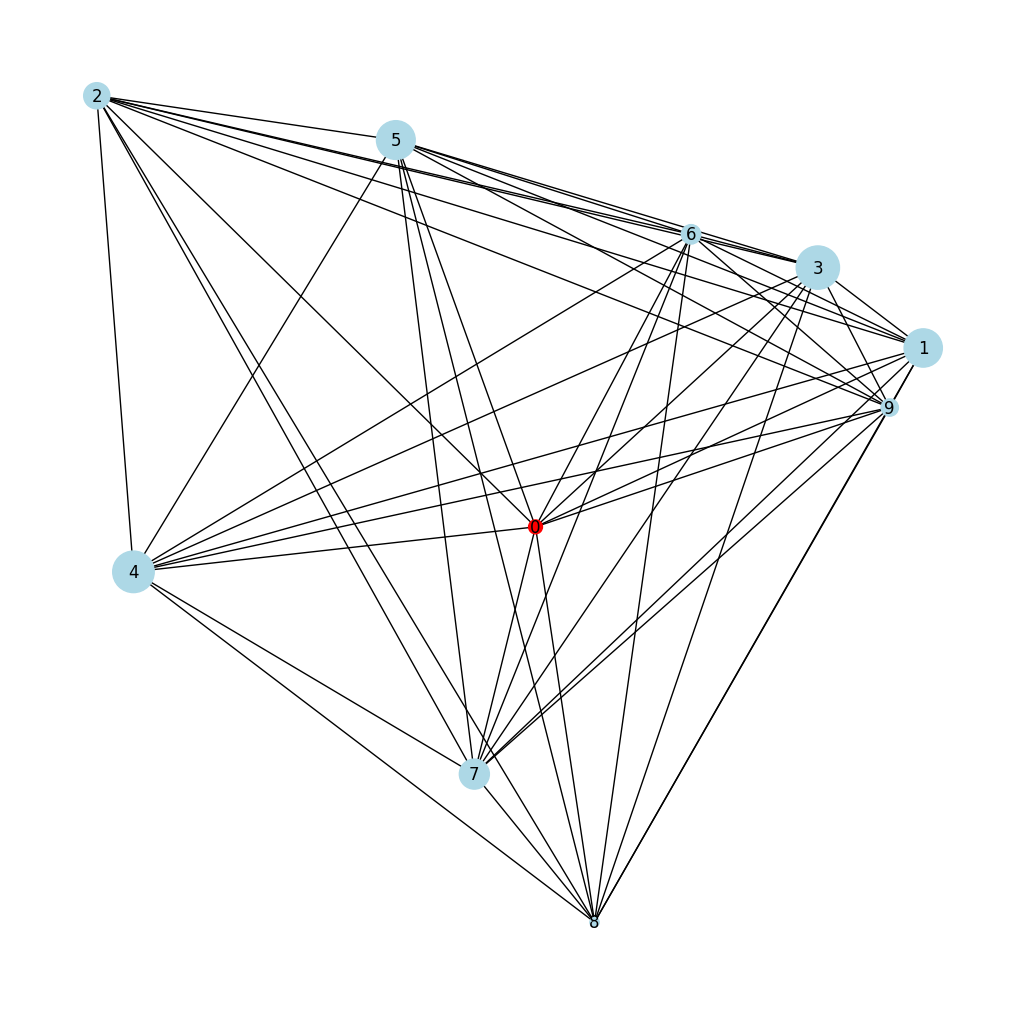

In [3]:
P = Problem(10, density=1, alpha=2, beta=1)
P.plot()

In [4]:
P.graph.nodes[9]

{'pos': (np.float64(0.8276311719925821), np.float64(0.6316643991220648)),
 'gold': 155.1352025754803}

In [5]:
logging.getLogger().setLevel(logging.WARNING)

ic(Problem(100, density=0.2, alpha=1, beta=1).baseline())
ic(Problem(100, density=0.2, alpha=2, beta=1).baseline())
ic(Problem(100, density=0.2, alpha=1, beta=2).baseline())
ic(Problem(100, density=1, alpha=1, beta=1).baseline())
ic(Problem(100, density=1, alpha=2, beta=1).baseline())
ic(Problem(100, density=1, alpha=1, beta=2).baseline())
ic(Problem(1_000, density=0.2, alpha=1, beta=1).baseline())
ic(Problem(1_000, density=0.2, alpha=2, beta=1).baseline())
ic(Problem(1_000, density=0.2, alpha=1, beta=2).baseline())
ic(Problem(1_000, density=1, alpha=1, beta=1).baseline())
ic(Problem(1_000, density=1, alpha=2, beta=1).baseline())
ic(Problem(1_000, density=1, alpha=1, beta=2).baseline())
None

ic| Problem(100, density=0.2, alpha=1, beta=1).baseline(): np.float64(38815.58297841784)
ic| Problem(100, density=0.2, alpha=2, beta=1).baseline(): np.float64(77458.9660062505)
ic| Problem(100, density=0.2, alpha=1, beta=2).baseline(): np.float64(24369662.257814802)
ic| Problem(100, density=1, alpha=1, beta=1).baseline(): np.float64(18266.18579582672)
ic| Problem(100, density=1, alpha=2, beta=1).baseline(): np.float64(36457.918462372065)
ic| Problem(100, density=1, alpha=1, beta=2).baseline(): np.float64(5404978.08899582)
ic| Problem(1_000, density=0.2, alpha=1, beta=1).baseline(): np.float64(358160.2546760439)
ic| Problem(1_000, density=0.2, alpha=2, beta=1).baseline(): np.float64(714872.4647578358)
ic| Problem(1_000, density=0.2, alpha=1, beta=2).baseline(): np.float64(198612615.83131713)
ic| Problem(1_000, density=1, alpha=1, beta=1).baseline(): np.float64(192936.23377726765)
ic| Problem(1_000, density=1, alpha=2, beta=1).baseline(): np.float64(385105.64149576554)
ic| Problem(1_000,

In [6]:
def precompute_distances(problem) -> np.ndarray:
    """
    Calcola matrice delle distanze tra tutte le coppie di nodi nel grafo del problema.
    Restituisce una matrice 2D numpy NxN dove l'elemento (i, j) rappresenta la distanza tra il nodo i e il nodo j.
    """
    graph = problem._graph
    num_cities = len(graph.nodes)

    print("Pre-calcolo delle distanze in corso...")

    # Inizializza una matrice NxN con tutti zeri
    dist_matrix = np.zeros((num_cities, num_cities))

    # NetworkX ha una funzione ottimizzata che calcola Dijkstra per tutte le coppie di nodi
    # Restituisce un iteratore di tuple (source, {target: distance, ...})
    all_pairs = nx.all_pairs_dijkstra_path_length(graph, weight='dist')

    # Popola la matrice delle distanze
    for source, targets in all_pairs:
        for target, distance in targets.items():
            dist_matrix[source, target] = distance

    print("Pre-calcolo delle distanze completato.")
    return dist_matrix

In [7]:
# Versione aggiornata di getSmartCost che utilizza la matrice delle distanze pre-calcolata

def getFastSmartCost(problem: Problem, solution: list[int], dist_matrix) -> float:
    """
    For each step, calculate the cost considering the accumulated weight using the precomputed distance matrix.
    """
    cost = 0
    weight = 0
    current_node = 0  # start from the node 0

    alpha = problem._alpha
    beta = problem._beta

    # Visit each city in the solution path
    for next_node in solution:
        # get distance from precomputed matrix
        dist_direct = dist_matrix[current_node][next_node]
        dist_to_0 = dist_matrix[current_node][0]
        dist_from_0 = dist_matrix[0][next_node]
        
        # Aggiorniamo il costo 
        cost_direct = dist_direct + (alpha * dist_direct * weight) ** beta

        cost_via_0 = dist_to_0 + (alpha * dist_to_0 * weight) ** beta + dist_from_0
        if cost_via_0 < cost_direct:
            cost += cost_via_0
            weight = 0
        else:
            cost += cost_direct
        
        weight += problem._graph.nodes[next_node].get('gold',1)
        current_node = next_node

    dist_final = dist_matrix[current_node][0]
    cost += dist_final + (alpha * dist_final * weight) ** beta

    return cost

In [8]:
class FinalACO:
    def __init__(self, problem, dist_matrix,
                 n_ants=30,
                 n_iterations=1000,
                 decay=0.1,
                 alpha=1,
                 beta=2,
                 q0=0.8,
                 stagnation_limit=100,
                 tau_min=0.01,
                 tau_max=5.0):
        self.problem = problem
        self.dist_matrix = dist_matrix
        self.n_cities = len(problem._graph.nodes)

        self.n_ants = n_ants
        self.n_iterations = n_iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta
        self.q0 = q0  # parametro ACS
        self.stagnation_limit = stagnation_limit  # limite di stagnazione
        self.tau_min = tau_min
        self.tau_max = tau_max

        # Inizializza la matrice dei feromoni.
        self.pheromones = np.ones((self.n_cities, self.n_cities)) * self.tau_max

        # Pre-calcola l'euristica (inverso della distanza)
        self.heuristic = 1 / (self.dist_matrix + 1e-10)  # Aggiungo un piccolo valore per evitare divisioni per zero

    def run(self):
        best_solution = None
        best_cost = float('inf')

        stagnation_counter = 0
        restarts = 0

        # lista per dati
        history = []

        print(f"Inizio ACS Min-Max con {self.n_cities} città, {self.n_ants} formiche, {self.n_iterations} iterazioni,q0={self.q0}, stagnation_limit={self.stagnation_limit}:")

        for iteration in range(self.n_iterations):

            iter_best_path = None
            iter_best_cost = float('inf')

            for _ in range(self.n_ants):
                path = self._build_path()
                cost = getFastSmartCost(self.problem, path, self.dist_matrix)

                if cost < iter_best_cost:
                    iter_best_cost = cost
                    iter_best_path = path.copy()

                if cost < best_cost:
                    best_cost = cost
                    best_solution = path.copy()
                    stagnation_counter = 0  # reset stagnation counter
            stagnation_counter += 1
            is_restart = 0 # flag per grafico

            # RESTART se stagnazione
            if stagnation_counter >= self.stagnation_limit:
                print(f"   >>> RESTART #{restarts} (Iter {iteration})")
                self.pheromones.fill(self.tau_max)
                stagnation_counter = 0
                restarts += 1
                is_restart = 1
            else:
                # Aggiornamento feromoni MinMax
                self.update_pheromones(best_solution, best_cost)

            # Salviamo dati per grafico
            history.append((iteration, best_cost, stagnation_counter, is_restart))

            # Log ogni tot.
            if iteration % 20 == 0:
                print(f"Iterazione {iteration + 1}/{self.n_iterations}, Costo migliore finora: {best_cost:.2f}, Stagnazione: {stagnation_counter}")

        print(f"Totale RESTART effettuati: {restarts}")
        return best_solution, best_cost, history
    
    def _build_path(self):
        curr = 0
        path = []
        # maschera booleana: True = non visitato
        unvisited = np.ones(self.n_cities, dtype=bool)
        unvisited[0] = False  # nodo 0 già visitato

        for _ in range(self.n_cities - 1):
            next_node = self._select_next_node_acs(curr, unvisited)
            path.append(next_node)
            unvisited[next_node] = False
            curr = next_node
        return path
    
    def _select_next_node_acs(self, curr, unvisited_mask):
        tau = self.pheromones[curr]
        eta = self.heuristic[curr]

        # calcolo punteggio per tutti i nodi
        scores = (tau ** self.alpha) * (eta ** self.beta)
        # azzero punteggi nodi già visitati
        scores[~unvisited_mask] = 0.0

        # se siamo in un vicolo cieco prendi il primo disponibile
        if scores.sum() == 0:
            return np.where(unvisited_mask)[0][0]
        
        # selezione ACS
        # generiamo un numero casuale tra 0 e 1
        if random.random() < self.q0:
            # Exploitation (Greedy Approach)
            # prendo il nodo con il punteggio più alto
            return np.argmax(scores)
        else:
            # Exploration (Roulette Wheel Selection)
            probabilities = scores / scores.sum()
            return np.random.choice(range(self.n_cities), p=probabilities)
        
    def update_pheromones(self, best_path, best_cost):
        """Aggiornamento globale: Evaporazione, Deposito dalla migliore soluzione, Min-Max"""
        
        # Evaporazione dei feromoni
        self.pheromones *= (1 - self.decay)

        # Deposito solo dalla migliore soluzione
        deposit = 1.0/best_cost

        from_nodes = [0] + best_path[:-1]
        to_nodes = best_path

        for u,v in zip(from_nodes, to_nodes):
            self.pheromones[u][v] += deposit
            self.pheromones[v][u] += deposit
        
        # ritorno a 0
        last_node = best_path[-1]
        self.pheromones[last_node][0] += deposit
        self.pheromones[0][last_node] += deposit

        # Applichiamo i limiti min-max
        self.pheromones = np.clip(self.pheromones, self.tau_min, self.tau_max)

In [9]:
POPULATION_SIZE = 50
MUTATION_RATE = 0.2
NUM_GENERATIONS = 2_000

In [10]:
def tweak(solution: list[int]) -> list[int]:
    """
    Applia un piccolo cambiamento (tweak) alla soluzione esistente
    scambiando due città nella lista.
    """
    if len(solution) < 2:
        return solution.copy()
    
    new_solution = solution.copy()
    i, j = random.sample(range(len(solution)), 2)
    new_solution[i], new_solution[j] = new_solution[j], new_solution[i]
    return new_solution

In [11]:
def init_population(problem: Problem, population_size: int) -> list[list[int]]:
    """
    Inizializza una popolazione di soluzioni casuali.
    Ogni soluzione è una permutazione casuale delle città (escluso il deposito 0).
    """
    num_cities = len(problem._graph.nodes)
    cities = list(range(1, num_cities))  # Escludo il deposito 0

    population = []
    for _ in range(population_size):
        individual = cities.copy()
        random.shuffle(individual)
        population.append(individual)
    return population

In [12]:
def tournament_selection(problem: Problem, population: list[list[int]], distance_matrix, tournament_size: int = 3):
    # Seleziono k individui casuali dalla popolazione
    candidates = random.sample(population, tournament_size)

    # Valuto chi tra loro a il costo migliore (minore)
    best_candidate = None
    best_cost = float('inf')

    for cand in candidates:
        cost = getFastSmartCost(problem, cand, distance_matrix)
        if cost < best_cost:
            best_cost = cost
            best_candidate = cand
    return best_candidate

In [13]:
def crossover(parent1: list[int], parent2: list[int]) -> list[int]:
    """
    Applica l'operatore di crossover Order Crossover (OX) per generare un figlio
    da due genitori.
    """
    size = len(parent1)

    # Scelgo due punti di taglio casuali
    start, end = sorted(random.sample(range(size), 2))

    # Creo il figlio con None e copiamo la parte centrale da parent1
    child = [None] * size
    child[start:end+1] = parent1[start:end+1] # serve "+1" per includere end

    # Riempio il resto del figlio con gli elementi di parent2 nell'ordine in cui appaiono
    # Lo faccio scorrendo il genitore2 e prendendo solo gli elementi non ancora presenti nel figlio
    p2_genes = [gene for gene in parent2 if gene not in child[start:end+1]]

    current_p2_index = 0
    for i in range(size):
        if child[i] is None:
            child[i] = p2_genes[current_p2_index]
            current_p2_index += 1
    return child

In [14]:
def mutation(individual: list[int], mutation_rate: float=0.1) -> list[int]:
    """
    Applica la mutazione alla soluzione scambiando due città con una certa probabilità.
    """
    if random.random() < mutation_rate:
        return tweak(individual)
    else:
        return individual

In [15]:
def genetic_algorithm(problem: Problem, distance_matrix, population_size: int = 50, generations: int = 1000, mutation_rate: float= 0.1):
    # Inizializzo la popolazione
    population = init_population(problem, population_size)

    best_solution = None
    best_cost = float('inf')

    print(f"Inizio Genetic Algorithm con population_size={population_size}, generations={generations}, mutation_rate={mutation_rate}")

    for gen in range(generations):
        new_population = []

        # --- ELITISMO ---
        # Salviamo subito il migliore della vecchia generazione nella nuova popolazione
        # Questo garantisce che la qualità non peggiori
        population.sort(key=lambda x: getFastSmartCost(problem, x, distance_matrix))
        best_of_gen = population[0]
        cost_of_gen = getFastSmartCost(problem, best_of_gen, distance_matrix)

        if cost_of_gen < best_cost:
            best_cost = cost_of_gen
            best_solution = best_of_gen.copy()
            print(f"Generation {gen}: Nuovo Record {best_cost:.2f}")

        new_population.append(best_of_gen)
        # -----------------

        # Riempiamo il resto della nuova popolazione (population_size - 1)
        while len(new_population) < population_size:
            # Parent Selection
            parent1 = tournament_selection(problem, population, distance_matrix)
            parent2 = tournament_selection(problem, population, distance_matrix)

            # Crossover
            child = crossover(parent1, parent2)

            # Mutation
            child = mutation(child, mutation_rate)

            new_population.append(child)
    
        # Sostituiamo la vecchia popolazione con la nuova
        population = new_population

    return best_solution, best_cost


In [ ]:
import pandas as pd
import time

# 1. Configurazione dei Test
test_cases = [
    # (N, Density, Alpha, Beta)
    # Casi 100 Città
    (100, 0.2, 1, 1),
    (100, 0.2, 2, 1),
    (100, 0.2, 1, 2), # Attenzione: Beta=2 fa esplodere i costi!
    (100, 1.0, 1, 1),
    (100, 1.0, 2, 1),
    (100, 1.0, 1, 2),
    
    # Casi 1000 Città (Attenzione ai tempi!)
    # Per il test rapido, magari commenta questi e provali in un secondo momento
    # (1000, 0.2, 1, 1), 
    # (1000, 1.0, 1, 1),
]

results = []

print(f"{'SCENARIO':<30} | {'BASELINE':<12} | {'GA':<12} | {'ACO':<12} | {'WINNER':<10}")
print("-" * 90)

for n_cities, dens, alpha, beta in test_cases:
    
    # A. Setup Problema
    problem = Problem(n_cities, density=dens, alpha=alpha, beta=beta)
    dist_matrix = precompute_distances(problem) # Fondamentale!
    
    # B. Calcolo Baseline
    start = time.time()
    base_cost = problem.baseline()
    base_time = time.time() - start
    
    # C. Esecuzione Genetic Algorithm
    # Parametri ottimizzati standard
    start = time.time()
    _, ga_cost = genetic_algorithm(
        problem, 
        dist_matrix, 
        population_size=50, 
        generations=1000, # Per 1000 città servirebbero di più
        mutation_rate=0.2
    )
    ga_time = time.time() - start
    
    # D. Esecuzione ACO (Final Version)
    start = time.time()
    # Riduciamo un po' le iterazioni per il benchmark rapido
    iter_aco = 1000 if n_cities == 100 else 200 # Meno iter per 1000 città se vuoi finire oggi
    
    aco = FinalACO(
        problem, 
        dist_matrix, 
        n_ants=30, 
        n_iterations=iter_aco, 
        decay=0.1, 
        alpha=1, 
        beta=2,
        q0=0.0, 
        stagnation_limit=200
    )
    best_path, aco_cost, history_data = aco.run() # Modifica run() se ritorna 3 valori, qui ne prendiamo 2
    aco_time = time.time() - start
    
    # E. Determina Vincitore
    costs = {'Base': base_cost, 'GA': ga_cost, 'ACO': aco_cost}
    winner = min(costs, key=costs.get)
    
    # F. Salvataggio Dati
    scenario_name = f"N={n_cities} D={dens} a={alpha} b={beta}"
    
    results.append({
        'N': n_cities,
        'Dens': dens,
        'Alpha': alpha,
        'Beta': beta,
        'Base Cost': base_cost,
        'GA Cost': ga_cost,
        'GA Time': ga_time,
        'ACO Cost': aco_cost,
        'ACO Time': aco_time,
        'Winner': winner,
        'Gap GA (%)': (ga_cost - base_cost) / base_cost * 100,
        'Gap ACO (%)': (aco_cost - base_cost) / base_cost * 100
    })
    
    print(f"{scenario_name:<30} | {base_cost:<12.2f} | {ga_cost:<12.2f} | {aco_cost:<12.2f} | {winner:<10}")

# Creazione DataFrame finale per analisi dettagliata
df = pd.DataFrame(results)

SCENARIO                       | BASELINE     | GA           | ACO          | WINNER    
------------------------------------------------------------------------------------------
Pre-calcolo delle distanze in corso...
Pre-calcolo delle distanze completato.
Inizio Genetic Algorithm con population_size=50, generations=1000, mutation_rate=0.2
Generation 0: Nuovo Record 30481.74
Generation 3: Nuovo Record 29235.24
Generation 4: Nuovo Record 28946.29
Generation 6: Nuovo Record 28737.61
Generation 8: Nuovo Record 28256.83
Generation 9: Nuovo Record 28060.34
Generation 10: Nuovo Record 27896.77
Generation 12: Nuovo Record 27874.15
Generation 13: Nuovo Record 27866.16
Generation 14: Nuovo Record 27673.13
Generation 15: Nuovo Record 27395.93
Generation 16: Nuovo Record 27349.65
Generation 18: Nuovo Record 27189.07
Generation 19: Nuovo Record 27007.35
Generation 22: Nuovo Record 26840.31
Generation 24: Nuovo Record 26822.57
Generation 27: Nuovo Record 26532.67
Generation 31: Nuovo Record 26437.

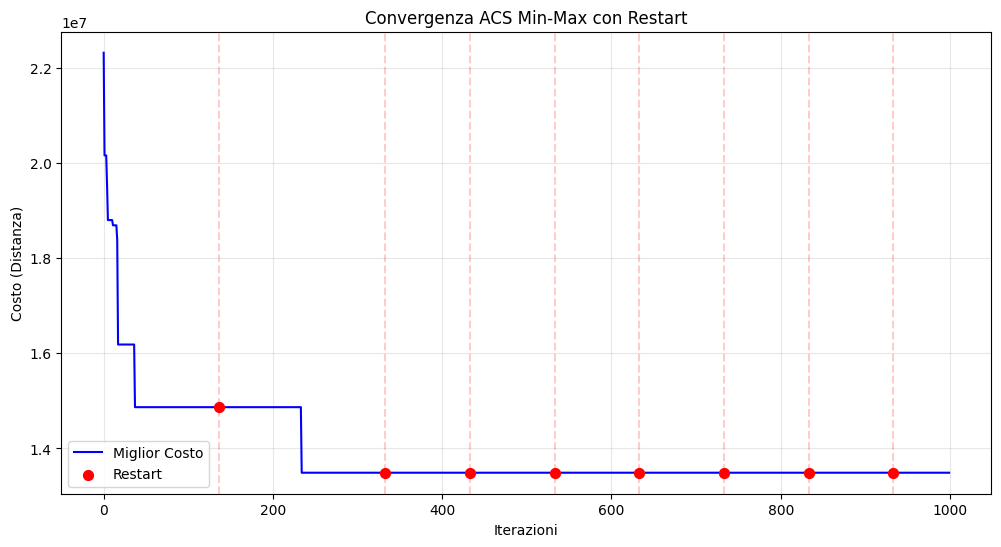

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Creiamo il DataFrame dalla history
# history contiene: (iteration, best_cost, stagnation_counter, is_restart)
df_history = pd.DataFrame(history_data, columns=['Gen', 'Cost', 'Stagnation', 'Restart'])

plt.figure(figsize=(12, 6))

# 1. Linea dell'andamento del costo
sns.lineplot(data=df_history, x='Gen', y='Cost', label='Miglior Costo', color='blue')

# 2. Evidenziamo i Restart con dei puntini rossi o linee verticali
restarts = df_history[df_history['Restart'] == 1]
if not restarts.empty:
    plt.scatter(restarts['Gen'], restarts['Cost'], color='red', s=50, zorder=5, label='Restart')
    for gen in restarts['Gen']:
        plt.axvline(x=gen, color='red', alpha=0.2, linestyle='--')

plt.title('Convergenza ACS Min-Max con Restart')
plt.xlabel('Iterazioni')
plt.ylabel('Costo (Distanza)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [20]:
# Mostra la tabella ordinata per scenario
print("\n--- ANALISI DETTAGLIATA ---")
# Formattiamo i numeri grandi per leggibilità
pd.options.display.float_format = '{:,.2f}'.format
print(df[['N', 'Dens', 'Alpha', 'Beta', 'Base Cost', 'GA Cost', 'ACO Cost', 'Winner']])

# Chi ha vinto più volte?
print("\n--- CONTEGGIO VITTORIE ---")
print(df['Winner'].value_counts())


--- ANALISI DETTAGLIATA ---
     N  Dens  Alpha  Beta     Base Cost      GA Cost      ACO Cost Winner
0  100  0.20      1     1     38,815.58    25,247.60     33,196.04     GA
1  100  0.20      2     1     77,458.97    50,408.35     67,899.10     GA
2  100  0.20      1     2 24,369,662.26 8,561,179.21 20,396,445.96     GA
3  100  1.00      1     1     18,266.19    18,255.21     23,879.84     GA
4  100  1.00      2     1     36,457.92    36,451.49     45,966.34     GA
5  100  1.00      1     2  5,404,978.09 4,247,825.84 13,490,606.96     GA

--- CONTEGGIO VITTORIE ---
Winner
GA    6
Name: count, dtype: int64
